## Setup

In [3]:
# Install required packages in a virtual environment (Requires Python 3.11.9)
%pip install --upgrade pip
%pip install numpy==1.26.3
%pip install pandas==2.2.2
%pip install matplotlib==3.9.0

# Option A: Nvidia GPU Cuda accelerated
%pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 --index-url https://download.pytorch.org/whl/cu121

# Option B: Unaccelerated CPU option
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

%pip install pyswarms==1.3.0

import os  # Import OS module for operating system-specific functions

# Import required libraries
import pandas as pd  # Import Pandas for CSV processing and data manipulation
import numpy as np  # Import NumPy for numerical computations
import matplotlib as mpl  # Import Matplotlib for data visualization
import matplotlib.pyplot as plt  # Import Matplotlib's pyplot module for plotting
import torch  # Import PyTorch for deep learning
import pyswarms as ps  # Import PySwarms for swarm intelligence optimization

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
if torch.cuda.is_available():
    my_device = torch.device("cuda")
    print("nvidia gpu with cuda available")
else:
    my_device = torch.device("cpu")
    print("nvidia gpu not available, running on cpu")
# Check if nvidia gpu cuda acceleration is available for pytorch

nvidia gpu with cuda available


## PWM and Rotational Interval of a Model Train Motor

### What is PWM?

**PWM (Pulse Width Modulation)** is a technique used to control the speed of a motor. It works by rapidly switching the voltage supply to the motor on and off, creating a series of pulses. The width of these pulses determines the average voltage supplied to the motor, which in turn controls the motor's speed.

### PWM Scale

In our datasets, **PWM values range from 0.0 to 1.0**, where:

* **0.0** represents a 0% duty cycle (no pulses always 0V, 0% power)
* **0.5** represents a 50% duty cycle (Half off, half on, 50% power)
* **1.0** represents a 100% duty cycle (no pulses always at source voltage, 100% power)

#### Example with 5V source voltage:

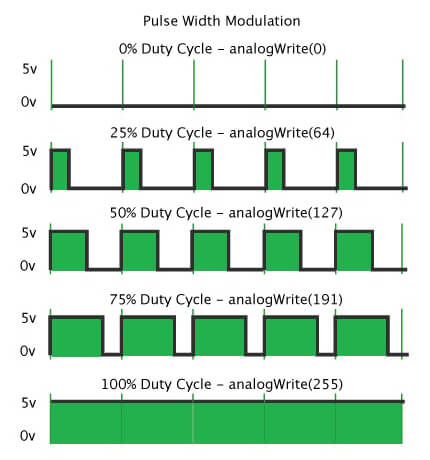

### Rotational Interval

The **Rotational Interval** refers to the time it takes for the motor to complete one full rotation. I measured it in seconds (s) using a hall effect sensor and a magnet on the motor shaft. In my datasets, rotational intervals are measured on a scale from **0.0 to 1.0 seconds**, where:

* Values between **0.0** and **1.0** seconds indicate the motor is rotating normally
* Values **greater than 1.0 seconds** indicate the motor is stalled or stopped

## Understanding Features, Labels, and the Input for this Neural Network

**A Feature** is a set of values from columns in our dataset that we use to make predictions. They're like a set of clues that help us solve the mystery!

**Label(s)** is the data point(s) in our dataset that we're trying to predict. They can have their own column in the dataset or they can be a future value from a feature. They're like the answers to our mystery!

**Input** is the the combination of the Features we feed into our model to make predictions. It's the combination of the Features

#### How do they relate?

Here's a Mermaid chart to help illustrate the relationships in this model:
```mermaid
graph LR
    M(Target Speed)

    subgraph Training
        subgraph Training Data Preparation
        A(Dataset)
        W(PWMs)
            subgraph Data Window - made in batches
                C(Label - Future PWM  - The PWM that causes the future Speed)
                Y(Feature - Past PWM Values )
                B(Feature - Past and Future Speeds)
            end
        end
        subgraph Model Evaluation
            I(Loss Calculation)
        end
    end

    X(Input)

    subgraph Neural Network Model
        D(Input Layer)
        E(Hidden Neural Layers)
        G(Output Single Neuron Layer)
    end

    subgraph Real World
        subgraph Real World Data
            K(Feature - Past and Future Speeds)
            J(Feature - Past PWM Values)
        end
        subgraph Output
            H(Future PWM Guess)
        end
    end

    N(Motor)

    W --> C
    W --> Y
    A --> W
    A --> B
    B -.-> X
    D ==> E ==> G
    G --> H
    G -.->|Future PWM Guess| I
    C -.->|Correct Future PWM Label| I
    Y -.-> X
    K --> X
    J --> X
    M --> K
    H --> N
    X --> D
```

## The Model Train Motor datasets

The datasets can be found in the Training Data folder of this repo...

In [5]:
# Get the current working directory
cwd = os.getcwd()

csv_paths = [
    # os.path.relpath("trainigData\\Sentinel_4wDM_ Hood_Foward_ Test.csv", start=cwd),
    # os.path.relpath("trainigData\\Sentinel_4wDM_Hood_Forward_Playground.csv", start=cwd),
    # os.path.relpath("trainigData\\Sentinel_4wDM_ Bi_ Slow.csv", start=cwd),
    os.path.relpath("trainigData\\Sentinel_4wDM_ Bi_ NN_with_Noise.csv", start=cwd),
]

# Load the CSV files
df = pd.concat((pd.read_csv(path) for path in csv_paths), ignore_index=True)

# convert from 64bit to 32bit float (to speed up training)
df = df.astype("float32")

# Shift the RotationInterval column down by 1
# This is so that the PWM to be predicted is the row below the rotationInterval that was caused by it
df["PWMDutyCycle(0-1)"] = df["PWMDutyCycle(0-1)"].shift(1).fillna(0.0)

# Take a glance at the data
print(df)

       RotationInterval(0-1s)  PWMDutyCycle(0-1)
0                    1.000000             0.0000
1                    1.000000             0.0000
2                    1.000000             0.0000
3                    1.000000             0.0000
4                    0.059650             0.0000
...                       ...                ...
72848                1.000000             0.0000
72849                0.026095             0.0000
72850                0.008750             0.8657
72851                0.009024             0.8623
72852                0.002748             0.9001

[72853 rows x 2 columns]


## View the Dataset as a parameter flow plot:
Kinda like optical flow but for a the state parameters of a motor

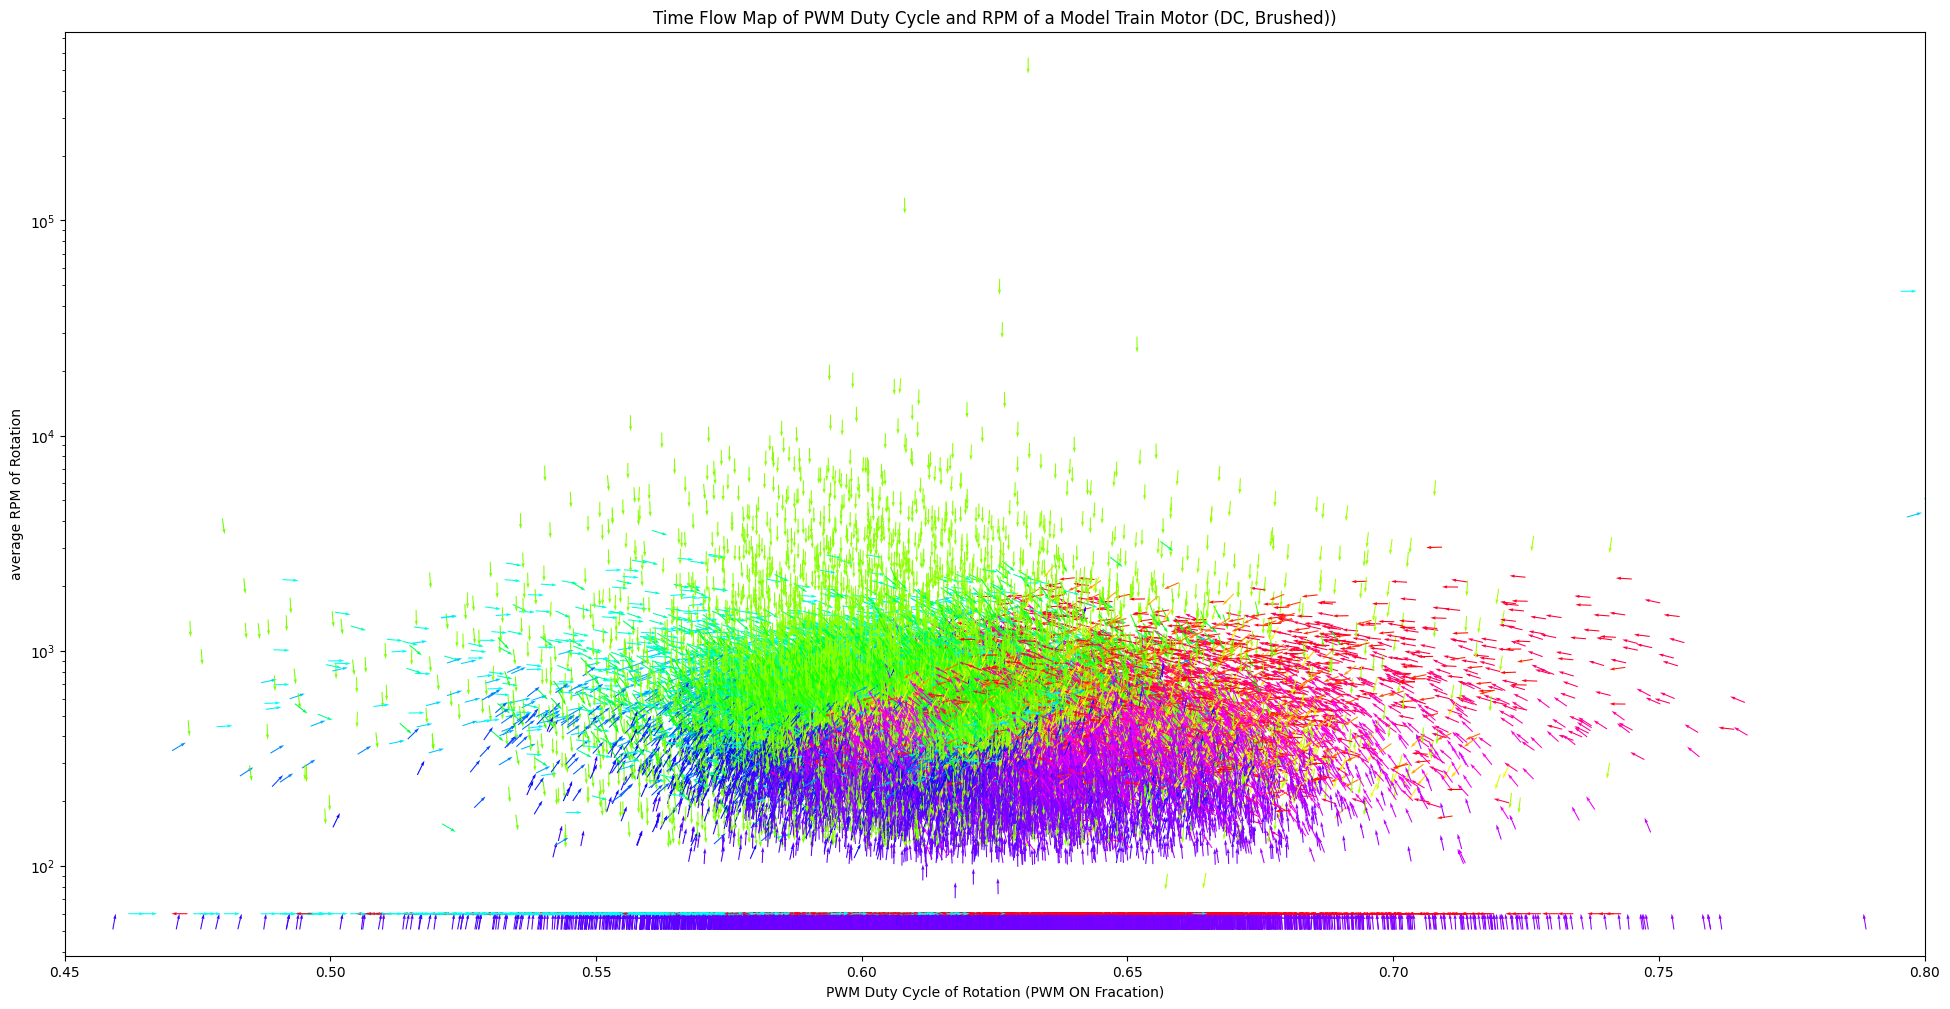

In [6]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.set_title("Time Flow Map of PWM Duty Cycle and RPM of a Model Train Motor (DC, Brushed))")

# Calculate the differences in PWM Duty Cycle and Rotation Interval
duty_cycle_diff = np.diff(df["PWMDutyCycle(0-1)"])
rotation_interval_diff = np.diff(df["RotationInterval(0-1s)"])

# Normalize the differences to improve visualization
scale_factor = np.hypot(duty_cycle_diff, rotation_interval_diff)
scale_factor[ scale_factor == 0 ] = np.nan  # Replace zeros with NaN to avoid /0 errors

duty_cycle_diff_normalized = np.nan_to_num(duty_cycle_diff / scale_factor)
rotation_interval_diff_normalized = np.nan_to_num(rotation_interval_diff / scale_factor)

# Convert Rotation Interval to RPM
rpm = 60 / df["RotationInterval(0-1s)"][1:]

# Create a quiver plot with colored arrows based on angle
Q = ax.quiver(
    df["PWMDutyCycle(0-1)"][:-1],
    rpm,
    duty_cycle_diff_normalized,
    rotation_interval_diff_normalized,
    np.arctan2(rotation_interval_diff_normalized, duty_cycle_diff_normalized),
    units="x",
    pivot="tip",
    width=0.0002,
    scale=1 / 0.003,
    cmap="hsv",
)

ax.set_xlabel("PWM Duty Cycle of Rotation (PWM ON Fracation)")
ax.set_ylabel("average RPM of Rotation")
ax.set_xlim(0.45, 0.8)  # Set x-axis limits
ax.set_yscale("log")  # Set y-axis to logarithmic scale

plt.show()

#### Plot Explanation
##### Key Elements

* **Arrow Head**: Location of the datapoint
* **Arrow Direction**: Points towards the next datapoint in the series
* **Colour**: Represents arrow angle (arrows in the same direction have the same colour)

## Identify Bad Data in Dataset

In [7]:
# Identify out of range Data Points
problem_data = [
    f"Row {index}: Value out of range ({row[col]})"
    for index, row in df.iterrows()
    for col in ["PWMDutyCycle(0-1)", "RotationInterval(0-1s)"]
    if (row[col] < 0) or (row[col] > 1)
]

# Verify motor stop and run rotations every 250 data points
rotation_interval_issues = []
for i in range(0, len(df), 50):
    # Check for motor stopped
    if 1.0 not in df["RotationInterval(0-1s)"].iloc[i : i + 250].values:
        rotation_interval_issues.append(f"No Stop Point in range {i}-{i+250}")
    # Check for motor running
    if not (df["RotationInterval(0-1s)"].iloc[i : i + 250].values < 1.0).any():
        rotation_interval_issues.append(f"No Running Point in range {i}-{i+250}")


problem_data.extend(rotation_interval_issues)

# Print out the problem areas
print("Problem data points found:" if problem_data else "No problem areas found!")
for issue in problem_data:
    print(issue)

# Print out dataset stats
df.describe().transpose()

Problem data points found:
No Stop Point in range 72850-73100


,count,mean,std,min,25%,50%,75%,max
RotationInterval(0-1s),72853.0,0.441431,0.410054,0.000125,0.117479,0.183997,1.0000,1.0000
PWMDutyCycle(0-1),72853.0,0.563063,0.175656,0.000000,0.591200,0.611700,0.6313,0.9001


## View the Dataset as a 2D Histogram

Text(0, 0.5, 'Rotation Interval [s]')

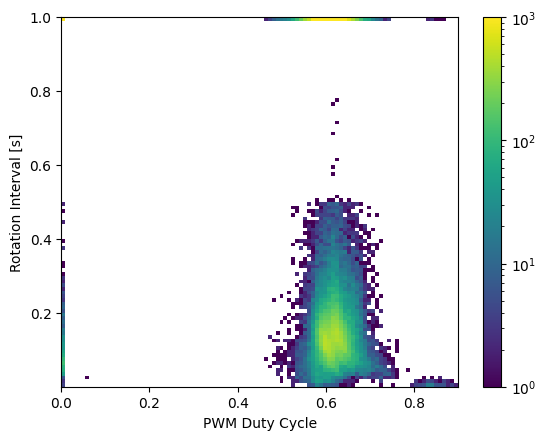

In [8]:
plt.hist2d(
    df["PWMDutyCycle(0-1)"],
    df["RotationInterval(0-1s)"],
    bins=(100, 100),
    norm=mpl.colors.LogNorm(vmin=1, vmax=1e3),
)
plt.colorbar()
plt.xlabel("PWM Duty Cycle")
plt.ylabel("Rotation Interval [s]")

# Create Dataset Class




In [9]:
import random

titles = [
    "Rotation Interval (Seconds from 0-1)",
    "Motor Driver PWM Duty Cycle (from 0-1 i.e. 0%-100%)",
]

feature_keys = [
    "RotationInterval(0-1s)",
    "PWMDutyCycle(0-1)",
]

from torch.utils.data import Dataset


class CustomMotorDataset(Dataset):
    def __init__(
        self,
        validation_split=0.2,
        validation=False,
        history_steps=16,
        label_feature_key="PWMDutyCycle(0-1)",
        transform=None,
        target_transform=None,
    ):
        self.history_steps = history_steps  # Number of time steps to look back
        self.label_column_index = df.columns.get_loc(label_feature_key)
        self.transform = transform
        self.target_transform = target_transform
        self.validation_split = validation_split
        self.validation = validation

        self.split_point = int(len(df) * (1.0 - validation_split))
        self.training_end = self.split_point - (self.history_steps + 1)
        self.validation_end = len(df) - (self.history_steps + 1)

    def __len__(self):
        if self.validation == True:
            return self.validation_end - self.split_point
        else:
            return self.training_end

    def __getitem__(self, idx):
        if self.validation == True:
            local_idx = idx + self.split_point
        else:
            local_idx = idx

        # if the motor is stopped then the pwm that caused it, is unsolvable
        # This solution does mean that the training data does have a bias for the first rotation after a stop, this is a feature not a bug
        # this bias is a helpful for improving kickstarts (the hardest problem for the model solve)
        future_Interval = 1.0
        while future_Interval == 1.0:
            input_data = df.iloc[local_idx : local_idx + self.history_steps].values
            label = np.array([df.iloc[local_idx + self.history_steps, self.label_column_index]])

            future_Interval = input_data[-1, 0]
            # print(future_Interval)
            local_idx+=1


        # Add random scale (helps to create a more generalized model for other motors)
        # minPWM, maxPWM = min(input_data[:, 1]), max(input_data[:, 1])
        # for i in range(100): #safety limit
        #     random_scale = random.gauss(1.0, .25)
        #     if maxPWM * random_scale <= 1.0 and minPWM * random_scale >= 0.0:
        #         break
        
        # input_data[:, 1] *= random_scale
        # label[:] *= random_scale
        

        return input_data, label

## Pytorch Dataloader Testing

In [10]:
from torch.utils.data import DataLoader

history_steps = 4
batches = 1

training_dataset = CustomMotorDataset(history_steps=history_steps)
training_dataloader = DataLoader(training_dataset, batch_size=batches, shuffle=True)

features, labels = next(iter(training_dataloader))
flattened_features = features.view(-1, features.shape[1] * features.shape[2]) #Reshape the tensor from 3D to 2D to help porting to the micro

print(f"Features\n----------\n Initial Shape (Batch, Depth, Channels): {features.size()}")
print(f" Initial {features}\n")
print(f" Flattened Shape (Batch, Depth): {flattened_features.size()}")
print(f" Flattened {flattened_features}")
print(f"\nLabels\n----------\n Shape (Batch, Depth): {labels.size()}")
print(f" {labels}\n")

Features
----------
 Initial Shape (Batch, Depth, Channels): torch.Size([1, 4, 2])
 Initial tensor([[[0.1052, 0.6234],
         [1.0000, 0.6066],
         [1.0000, 0.5888],
         [0.0771, 0.5680]]])

 Flattened Shape (Batch, Depth): torch.Size([1, 8])
 Flattened tensor([[0.1052, 0.6234, 1.0000, 0.6066, 1.0000, 0.5888, 0.0771, 0.5680]])

Labels
----------
 Shape (Batch, Depth): torch.Size([1, 1])
 tensor([[0.6337]])



# Dense Neural Network Model Creation

In [11]:
import torch.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:  # add ReLU for hidden layers
                layers.append(nn.ReLU())
        layers.append(nn.Sigmoid())  # Add activation function to the output neuron
        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, x.shape[1] * x.shape[2])  # Flatten input
        return self.stack(x)


# Example usage
# ============================================
model = NeuralNetwork(
    input_dim=16,  # input dimension (features)
    hidden_dims=[32, 64],  # hidden layer dimensions
    output_dim=1,  # output dimension
)


input = torch.rand(1, 8, 2)  # (batches, history_steps, features)
print(f"Random Input: {input}")
print(f"Model Output: {model(input)}\n\n")

print(f"Model structure\n==================\n{model}\n")

for name, param in model.named_parameters():
    print(f"Layer: {name}/s | Size: {param.size()}")

Random Input: tensor([[[0.4580, 0.5316],
         [0.5193, 0.2842],
         [0.9486, 0.4803],
         [0.7072, 0.2690],
         [0.1962, 0.9241],
         [0.5223, 0.0916],
         [0.0348, 0.2015],
         [0.6837, 0.3164]]])
Model Output: tensor([[0.4944]], grad_fn=<SigmoidBackward0>)


Model structure
NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Layer: stack.0.weight/s | Size: torch.Size([32, 16])
Layer: stack.0.bias/s | Size: torch.Size([32])
Layer: stack.2.weight/s | Size: torch.Size([64, 32])
Layer: stack.2.bias/s | Size: torch.Size([64])
Layer: stack.4.weight/s | Size: torch.Size([1, 64])
Layer: stack.4.bias/s | Size: torch.Size([1])


# Model Training and Validation

In [12]:
batch_size = 8 #number of samples from the dataset loader used for each 'pass' (back propagation through the model)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.to(my_device)  # Move the model to the specified device (GPU)
    model.train()  # Set the model to training mode - important for batch normalization and dropout layers

    # Move the entire dataloader to the GPU
    dataloader = [(X.to(my_device), y.to(my_device)) for X, y in dataloader]

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()


def validate_loop(dataloader, model, loss_fn, scheduler):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size: int = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(my_device), y.to(my_device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

    val_loss /= num_batches
    print(f"Avg Validation loss: {val_loss:>8f}")
    scheduler.step(val_loss)
    return val_loss


def train_model(model, history_steps):
    learning_rate = 1e-3
    epochs = 512
    patience = 4  # number of epochs to wait for improvement

    training_dataset = CustomMotorDataset(0.1, False, history_steps=history_steps)
    validation_dataset = CustomMotorDataset(0.1, True, history_steps=history_steps)

    training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

    model.to(my_device)

    improvement_count = 0
    best_validation_loss = float("inf")

    training_history = []
    validation_history = []

    for t in range(epochs):
        print(f"Epoch {t+1}")
        training_history.append(train_loop(training_dataloader, model, loss_fn, optimizer))
        validation_loss = validate_loop(validation_dataloader, model, loss_fn, scheduler)
        validation_history.append(validation_loss)

        if validation_loss < best_validation_loss -0.0001:
            best_validation_loss = validation_loss
            improvement_count = 0
        else:
            improvement_count += 1
            if improvement_count >= patience:
                break

    print("Done!")

    return training_history, validation_history

# Batch Training File Manager (JSON)

Model names are generated as: randomAnimalName_modelParameters_historySteps_layersNeuronCount

In [13]:
import json
import os
import random


class ModelManager:
    def __init__(self, file_path):
        self.file_path = file_path
        self.models = self.load_models()

    def load_models(self):
        if os.path.exists(self.file_path):
            with open(self.file_path, "r") as f:
                return json.load(f)
        else:
            return {}

    def save_models(self):
        self.load_models()
        with open(self.file_path, "w") as f:
            json.dump(self.models, f, indent=4)

    def add_model(self, model, layer_sizes, training_history, validation_history, history_steps):

        nodes = sum(
            layer_sizes
        )  # nodes = numbers of biases (each node has an internal bias value)
        parameters = sum(
            p.numel() for p in model.parameters()
        )  # parameters = number of weights(connections between nodes)
        parameters_size_kiB: float = (parameters * 4) / 1024  # assuming 32-bit floats

        epochs = len(validation_history)

        model_name = self.nameGenerator(parameters, layer_sizes, history_steps)

        layer_sizes = [x.item() for x in layer_sizes] # convert to python int

        self.models[model_name] = {
            "validation_loss": min(validation_history),
            "history_steps": history_steps.tolist(),
            "model_size": {
                "nodes": nodes.item(),  # convert to Python int,
                "layer_sizes": layer_sizes,
                "parameters": parameters,
                "parameters_size_kiB": parameters_size_kiB,
            },
            "training_history": {
                "epochs": epochs,
                "training_history": training_history,
                "validation_history": validation_history,
            },
        }
        return model_name

    def get_model(self, model_name):
        return self.models.get(model_name)

    def list_models(self):
        return list(self.models.keys())

    def delete_model(self, model_name):
        if model_name in self.models:
            del self.models[model_name]
            self.save_models()

    def nameGenerator(self, model_size, layer_sizes, history_steps, animal_names_file="random_animals.json"):
        if os.path.exists(animal_names_file):
            with open(animal_names_file, "r") as animals_file:
                animal_names = json.load(animals_file)

        layer_str = "-".join(str(size) for size in layer_sizes)
        animal_name = random.choice(animal_names)
        return f"{animal_name}_{model_size/1000:.0f}k_{history_steps}_{layer_str}"

    def visualize_loss(self, exclude_threshold=None):
        plt.figure(figsize=(24, 12))  # increased plot width and height

        for model_key in self.models.keys():
            if (
                exclude_threshold is not None
                and self.models[model_key]["validation_loss"] > exclude_threshold
            ):
                continue
            val_loss = self.models[model_key]["training_history"]["validation_history"]
            epochs = list(range(1, len(val_loss) + 1))
            plt.plot(epochs, val_loss, label=model_key, linewidth=0.5)  # narrower lines

        plt.yscale("log")  # logarithmic y-axis
        plt.ylim(top=1e-1)  # limit y-axis max to 10^-1

        plt.title("Validation Loss over time")
        plt.xlabel("Epochs")
        plt.ylabel("Validation Dataset Loss")
        plt.legend()
        plt.show()

    def visualize_performance(self, exclude_threshold=None):
        plt.figure(figsize=(24, 12))  # set plot size

        model_sizes = []
        val_losses = []
        model_labels = []

        for model_key in self.models.keys():
            if (
                exclude_threshold is not None
                and self.models[model_key]["validation_loss"] > exclude_threshold
            ):
                continue
            model_sizes.append(self.models[model_key]["model_size"]["parameters"])
            val_losses.append(self.models[model_key]["validation_loss"])
            model_labels.append(model_key)

        plt.scatter(model_sizes, val_losses)

        for i, txt in enumerate(model_labels):
            plt.annotate(txt, (model_sizes[i], val_losses[i]))

        plt.xlabel("Model Size (Number of Parameters)")
        plt.ylabel("Validation Loss")
        plt.title("Model Performance")

        plt.xscale("log")
        plt.yscale("log")

        plt.show()
        
    def get_best_loss(self, min_parameters, max_parameters):
        best_model = None
        best_validation_loss = float('inf')
        for model_name, model_data in self.models.items():
            parameters = model_data["model_size"]["parameters"]
            if min_parameters <= parameters <= max_parameters:
                validation_loss = model_data["training_history"]["validation_history"][0]
                if validation_loss < best_validation_loss:
                    best_model = model_name
                    best_validation_loss = validation_loss
        return best_validation_loss



model_manager = ModelManager("trained_models/model_overview.json")

# Batch Training Models

In [14]:
from IPython.display import clear_output
def generate_random_array(min_length, max_length, min_value, max_value, max_sum):
    for _ in range(255):  # limit the number of attempts
        array_length = random.randint(min_length, max_length)
        array = [random.randint(min_value, max_value) for _ in range(array_length)]
        if sum(array) <= max_sum:
            break
    return array

model_name = ""

def swarm_function(inputs_array):
    particles_output = []
    for particle_inputs in inputs_array:
        print(particle_inputs[0])

        history_steps = np.ceil(particle_inputs[0]).astype(int)
        history_steps = max(1, history_steps) #force >=1

        layer_dimensions = [np.ceil(particle_inputs[1]).astype(int)]
        layer_dimensions = [max(1, dim) for dim in layer_dimensions] #force >=1

        print(f"\nHistory steps = {history_steps}, layers = {layer_dimensions}, neuron count = {sum(layer_dimensions)}\n")

        model = NeuralNetwork(
            input_dim=history_steps * 2,  # input dimension
            hidden_dims=layer_dimensions,  # hidden layer dimensions
            output_dim=1,  # output dimension
        )

        training_history, validation_history = train_model(model, history_steps)

        model_name = model_manager.add_model(model, layer_dimensions, training_history, validation_history, history_steps)

        clear_output()
        model_manager.visualize_loss(exclude_threshold=0.004)
        model_manager.visualize_performance(exclude_threshold=0.004)
        model_manager.save_models()
        best_validation_loss:float = min(validation_history)
        parameters = sum(param.numel() for param in model.parameters())

        if best_validation_loss < model_manager.get_best_loss(parameters * 0.75, parameters * 1.25):
            model_folder = os.path.join(cwd, "trained_models")
            if not os.path.exists(model_folder):
                os.makedirs(model_folder)
            model_path = os.path.join(model_folder, f"{model_name}.pth")
            torch.save(model, model_path, _use_new_zipfile_serialization=True)

        particles_output.append(best_validation_loss)

    return np.array(particles_output)


print(model_name)

# Swarm Optimize History Steps and Neuron Count

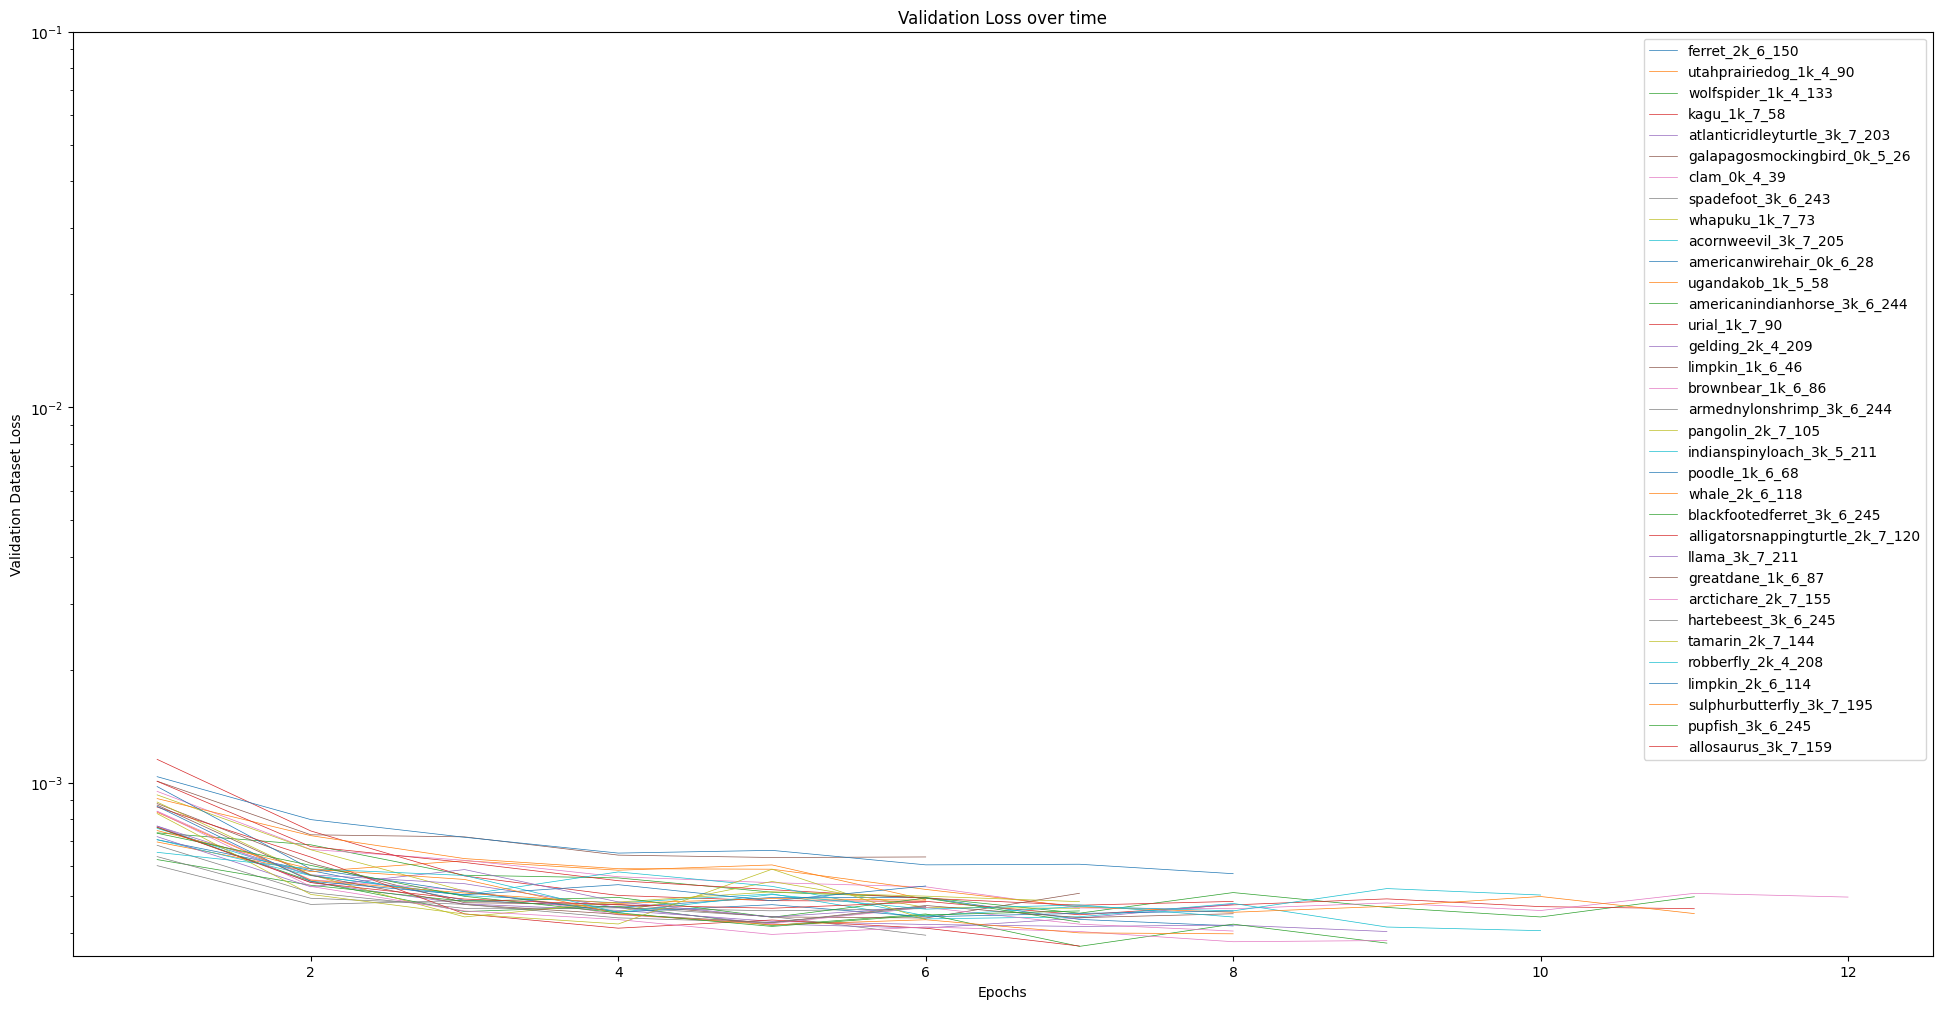

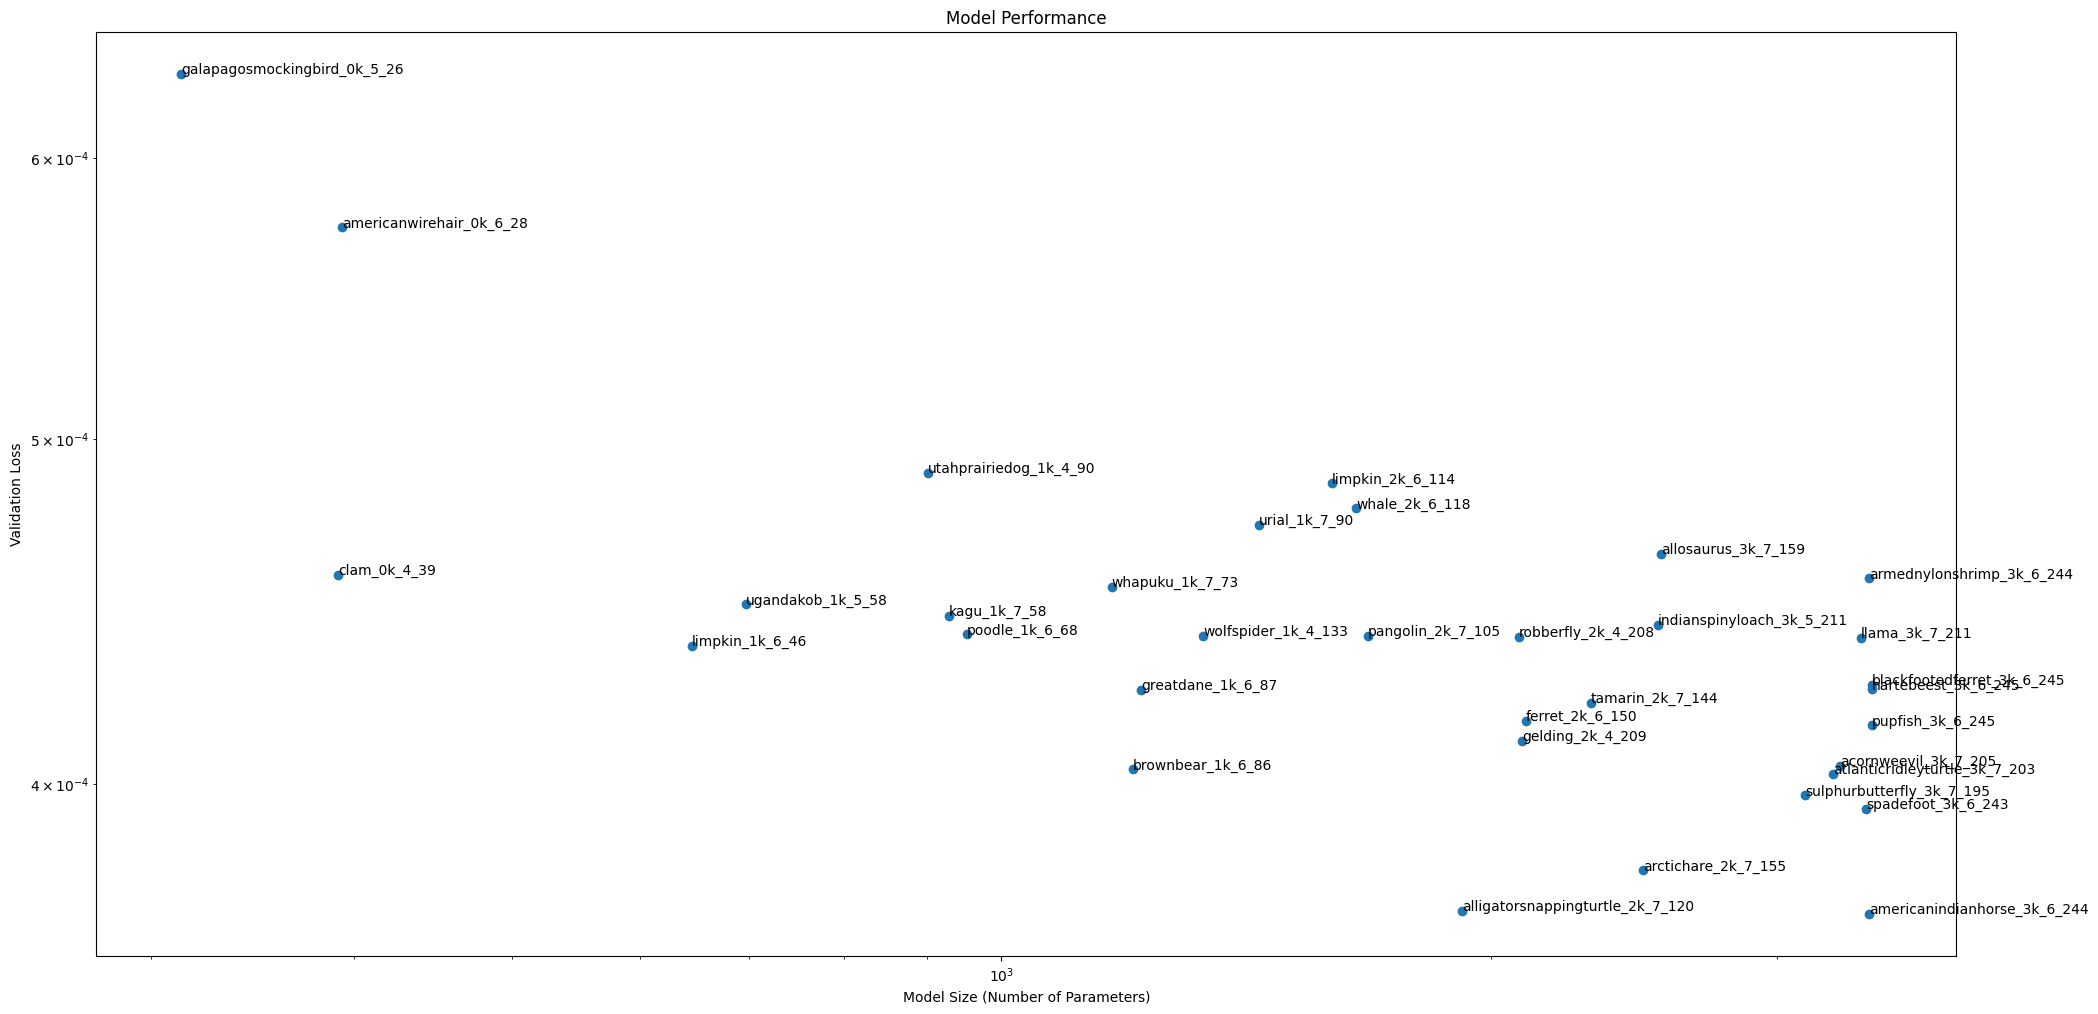

5.429309752201878

History steps = 6, layers = [204], neuron count = 204

Epoch 1
Avg Validation loss: 0.000642
Epoch 2
Avg Validation loss: 0.000611
Epoch 3


KeyboardInterrupt: 

In [17]:
# c1 = float cognitive parameter, c2 = float social parameter, w = float inertia
swarm_options = {"c1": 0.5, "c2": 0.1, "w": 0.9}
swarm_bounds = (np.array([3, 16]), np.array([7, 256])) # min(x,y),max(x,y)

print(swarm_bounds)

swarm_optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=2, options=swarm_options, bounds=swarm_bounds)

swarm_optimizer.optimize(swarm_function, iters=10, verbose=False)